# Personal Information
Name: **Zsofia Katona**

StudentID: **13160184**

Email: [**zsofia.katona@student.uva.nl**](zsofia.katona@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context

## Fish videos dataset
The dataset of fish videos has been recorded and annotated by the research group. It includes a total of 44 videos, each 10 seconds long, with a predator attack happening at the middle of the video (in an approximate 1-second timeframe around the middle). The resolution of the videos is 1080x1920 pixels, with 120 frames per second (meaning a total of 1276 frames for each video).

## Animal Kingdom
The Animal Kingdom dataset is a publicly available dataset [1] containing videos of animals collected from YouTube and annotated for different video understanding tasks. In this project, the focus is on the action recognition (AR) task. As described in [1], the AR dataset consists of a total of 50 hours of video clips, with over 850 animal species and 140 fine-grained action classes. As the main focus of the project is videos of fish predator attacks, the Animal Kingdom AR dataset will be narrowed down to clips which are related to this domain. **The EDA process shown in this notebook identifies and explores the relevant part of the Animal Kingdom AR dataset.**

[1] Xun Long Ng, Kian Eng Ong, Qichen Zheng, Yun Ni, Si Yong Yeo, Jun Liu; Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2022, pp. 19023-19034

# Data Description
Exploring the Animal Kingdom dataset.

In [1]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt

## Importing metadata about Action Recognition (AR) dataset

In [2]:
# Importing AR video metadata.
video_metadata = pd.read_excel('../assets/AK_AR_metadata.xlsx', sheet_name='AR')

video_metadata.head()

,S/N,video_id,type,labels,list_animal_action
0,1,AAACXZTV,train,"2,40","[('Common Crane', 'Attending'), ('Common Crane..."
1,2,AABCQPTK,train,"2,15","[('Singing Nightingale', 'Attending'), ('Singi..."
2,3,AABKMGHE,train,78,"[('Snake', 'Moving')]"
3,4,AACJGIQR,train,"102,1,39,8,120,97","[('Mongoose', 'Biting'), ('Black Mamba', 'Sens..."
4,5,AACKOHGA,train,"2,68,133,116","[('Meerkat', 'Walking'), ('Meerkat', 'Attendin..."


In [8]:
# Ensuring that labels and animal actions are represented as lists.
video_metadata['labels'] = video_metadata['labels'].apply(lambda labels: eval('[' + str(labels) + ']'))

video_metadata['list_animal_action'] = video_metadata['list_animal_action'].apply(eval)

In [3]:
print(f'Number of videos in dataset: {len(video_metadata)}')

distinct_IDs = video_metadata['video_id'].nunique()

print(f'Number of distinct video IDs: {distinct_IDs}')

Number of videos in dataset: 30100
Number of distinct video IDs: 30100


As can be seen, actions in the videos are represented in a list of (ACTOR, ACTION) tuples.

In [4]:
# Importing metadata about animal species in the dataset.
animal_data = pd.read_excel('../assets/AK_AR_metadata.xlsx', sheet_name='Animal')

animal_data.head()

,Animal,Parent Class,Class,Sub-Class,Young,Generic name
0,Abalone,Sea animal,Sea animal / Shellfish,Shellfish / Abalone / Clam / Mussel / Scallop,NaN,NaN
1,Acyrthosiphon pisum Aphid,Insect,Insect,Ant / Termite / Aphid,NaN,NaN
2,Aedes aegypti Mosquito,Insect,Insect,Mosquito / Crane fly,NaN,NaN
3,Aedes aegypti Mosquito Larva,Insect,Insect / Larva / Pupa,Larva / Pupa,Yes,NaN
4,Aesculapian Snake,Reptile,Reptile / Snake,Snake / Cobra / Viper / Python,NaN,NaN


# Finding relevant videos

## Finding videos with relevant species
Identifying videos showing fish.

In [5]:
# Saving list of fish species in the dataset.
fish = list(animal_data[animal_data['Class'] == 'Fish']['Animal'])

In [6]:
print('Number of fish species in dataset:', len(fish))
print('Examples:', fish[:3])

Number of fish species in dataset: 59
Examples: ['Archer Fish', 'Atlantic Blue Tang Fish', 'Barracuda Fish']


In [18]:
def check_species_from_list(actions, list_of_species):
    '''Checks if a video contains action performed by an animal from a list of species.'''

    for action_tuple in actions:
        species = action_tuple[0]

        if species in list_of_species:
            return True
        
    return False

In [19]:
fish_videos = video_metadata[video_metadata['list_animal_action'].apply(lambda actions: check_species_from_list(actions, fish))]

In [20]:
print('Number of fish videos in dataset:', len(fish_videos))

Number of fish videos in dataset: 887


## Finding videos with relevant actions
In our case, these are actions related to predation, namely:

* 1: **Attacking**
* 7: **Being eaten**
* 14: **Chasing**
* 47: **Fighting**
* 8: **Biting**
* 51: **Fleeing**
* 96: **Retaliating**
* 120: **Struggling**

In [21]:
relevant_actions = ['Attacking', 'Chasing', 'Fighting', 'Biting', \
                    'Being eaten', 'Fleeing', 'Retaliating', 'Struggling']

In [23]:
action_data = pd.read_excel('../assets/AK_AR_metadata.xlsx', sheet_name='Action')

for i in action_data[action_data['Action'].isin(relevant_actions)].index:
    print('--' + action_data['Action'][i])
    print(action_data['Description'][i])
    print()

--Attacking
Animal rushes and leaps on another another with bites, pecks or kicks

--Chasing
Animal "runs" after the fleeing animal, however no biting occurs

--Fighting
Include wrestling

--Fleeing
Different from escaping, animal 'runs' away from its predator or danger, often with rapid change of direction but without having been caught first

--Retaliating
Animal makes a defending attack (i.e., "attacks" its attacker back). Include ramming by goats

--Struggling
Animal struggles from the clutch, grip, or bite by its predator

--Biting
Animal sinks its teeth into the object or animal, but does not eat / feed / chew on the object or food

--Being eaten
nan



## Collecting relevant videos

Please note that during the selection of relevant videos, only clips in which fish are the performers of attack-related actions (either on the predator or prey side) are selected. However, the clip might contain animals other than fish, and they might be involved in the attack as well (e.g., snake eating fish).

In [25]:
def is_relevant_video(actions_in_video, relevant_actions, relevant_species):
    '''Checks if a video contains a relevant action performed by a releveant species.'''

    for action_tuple in actions_in_video:
        species, action = action_tuple

        if species in relevant_species and action in relevant_actions:
            return True
        
    return False

In [26]:
# Narrowing the dataset to only relevant fish videos (i.e., the ones containing attack-related action performed by fish.)
relevant_videos = fish_videos[fish_videos['list_animal_action'].apply(lambda actions: \
                                                                      is_relevant_video(actions, relevant_actions, fish))]

print('Number of relevant videos in dataset:', len(relevant_videos))

Number of relevant videos in dataset: 81


In [30]:
print('Number of relevant training samples:', len(relevant_videos[relevant_videos['type'] == 'train']))
print('Number of relevant test samples:', len(relevant_videos[relevant_videos['type'] == 'test']))

Number of relevant training samples: 74
Number of relevant test samples: 7


# Inspecting relevant action videos

In [34]:
# Setting up counters to record the distribution of actions and species in the relevant videos.
action_counter = {action : 0 for action in relevant_actions}

species_counter = {}

In [35]:
for i in relevant_videos.index:
    actions = relevant_videos.loc[i, 'list_animal_action']

    for action_tuple in actions:
        species, action = action_tuple

        if species in fish and action in relevant_actions: 
            if species not in species_counter:
                species_counter[species] = 1

            else:
                species_counter[species] += 1

            action_counter[action] += 1

## Distribution of relevant action types

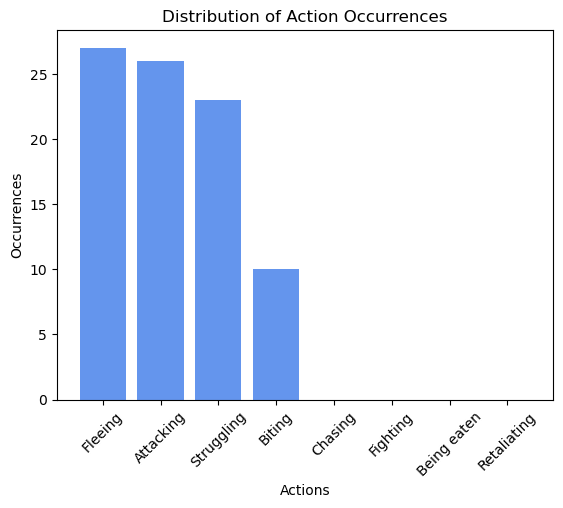

In [51]:
sorted_items = sorted(action_counter.items(), key=lambda x: x[1], reverse=True)

actions, occurrences = zip(*sorted_items)

plt.bar(actions, occurrences, color='cornflowerblue')
plt.xlabel('Actions')
plt.ylabel('Occurrences')
plt.title('Distribution of Action Occurrences')
plt.xticks(rotation=45)
plt.show()

## Distribution of different fish species in relevant actions

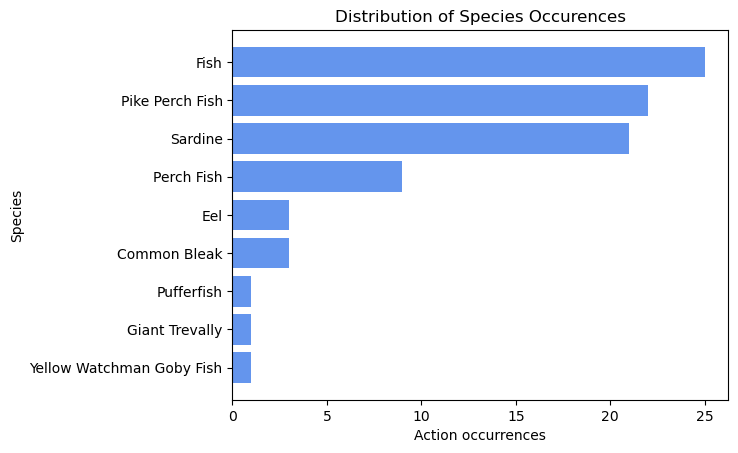

In [38]:
sorted_items = sorted(species_counter.items(), key=lambda x: x[1], reverse=False)

species, occurrences = zip(*sorted_items)

plt.barh(species, \
        occurrences, \
            color='cornflowerblue')
plt.ylabel('Species')
plt.xlabel('Action occurrences')
plt.title('Distribution of Species Occurences')
plt.show()

## Exploring possibility of "baseline" actions.
The project builds on a binary classification task: predicting whether a video clip contains a predator attack or not. While the positive ("attack") examples can be collected using the action categories shown above, negative samples can either contain any fish video, or any fish video which contains a fish labelled as swimming. The latter is an option to ensure that only videos of moving fish are used. This section aims to explore the prevalence of "swimming" labels in fish videos of the AR dataset.

In [49]:
# Counting videos in which fish swim:

relevant_video_ids = list(relevant_videos['video_id'])

swim_counter = 0
swim_counter_in_predation = 0 # Number of videos in which there is fish predation AND swimming.

for i in fish_videos.index:
    actions = fish_videos.loc[i, 'list_animal_action']

    for action_tuple in actions:
        species, action = action_tuple

        if species in fish and action == 'Swimming':
            swim_counter += 1

            if fish_videos.loc[i, 'video_id'] in relevant_video_ids:
                swim_counter_in_predation += 1

            continue # Count each video only once.

In [50]:
print(f'Number of videos with fish labelled as swimming: {swim_counter}')
print(f'Number of videos with fish in predation and fish labelled as swimming: {swim_counter_in_predation}')

Number of videos with fish labelled as swimming: 504
Number of videos with fish in predation and fish labelled as swimming: 38
